In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import os

from script.curate_training_test_data import  curate_training_test_data_many
from script.generate_lstm_keras_multistep import train_lstm_multi_step, generate_lstm_multi_step
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [3]:
df_all = pd.read_csv('eua_price_data.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all = df_all[(df_all['Date'] > pd.to_datetime('2020-11-24')) & (df_all['Date'] < pd.to_datetime('2024-10-07'))].reset_index(drop=True)

In [2]:
## for seungwoo
# df_all_open_n_high = pd.read_csv('merged_data.csv', thousands=',')
# df_all_open_n_high['Date'] = pd.to_datetime(df_all_open_n_high['Date'], format='%Y-%m-%d')  
# df_all_open_n_high = df_all_open_n_high.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
# df_all_open_n_high = df_all_open_n_high[(df_all_open_n_high['Date'] > pd.to_datetime('2020-11-24')) & (df_all_open_n_high['Date'] < pd.to_datetime('2024-10-07'))].reset_index(drop=True)
# df_all = pd.merge(left = df_all, right = df_all_open_n_high[['Date', 'High_price', 'Low_price']], how = 'left', left_on = 'Date', right_on = 'Date')
# df_all.head()

In [4]:
# predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',] #'High_price', 'Low_price']
# test_date = '2024-08-01'

# folder_name = "result_LSTM_multistep"
# modeltype='lstm_v2'

# for sequence_length in [28]:

#     original_EUA = df_all['EUA'].values  
#     dates = df_all['Date'].values
#     last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
#     X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
#                                                 df_all, 
#                                                 flatten=False,
#                                                 sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
#                                                 sequence_length_out=28,  # 입력 시퀀스 길이 (30일)
#                                                 test_date=test_date,
#                                                 predictors_lst=predictors_lst
#                                             )

#     checkpoint_path = f"./{folder_name}/{modeltype}_ts_{sequence_length}.keras"

#     model = generate_lstm_multi_step(X_train, y_train)
#     history = train_lstm_multi_step(model, checkpoint_path, X_train, y_train,
#                                     batch_size = 128, epochs = 100)
#     model.load_weights(checkpoint_path) 

#     # # accuracy plot
#     # train_predictions = model.predict(X_train, verbose = 0);
#     # train_predictions_rescaled = scaler.inverse_transform(train_predictions.reshape(-1, len(predictors_lst)))
#     # test_predictions = model.predict(X_test, verbose = 0);
#     # test_predictions_rescaled = scaler.inverse_transform(test_predictions.reshape(-1, len(predictors_lst)))


In [118]:
from script.generate_lstm_pytorch_multistep import *
import torch 

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',] #'High_price', 'Low_price']
test_date = '2018-08-01'

folder_name = "result_LSTM_pytorch_multisteps"
if os.path.isdir(folder_name) is not True:
    os.mkdir(folder_name)
modeltype = 'lstm_gpu_v10_more_dropout'
sequence_length = 28

original_EUA = df_all['EUA'].values  
dates = df_all['Date'].values
last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                            df_all, 
                                            flatten=False,
                                            sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                            sequence_length_out=28,  # 입력 시퀀스 길이 (30일)
                                            test_date=test_date,
                                            predictors_lst=predictors_lst,
                                            dtype = 'float32',
                                            is_test_split = False,
                                        )

checkpoint_path = f"./{folder_name}/{modeltype}_ts_{sequence_length}.keras"

# Convert to PyTorch tensor
X_train_tensor, y_train_tensor = torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device)
model = generate_lstm_multi_step(X_train_tensor, y_train_tensor)
history = train_lstm_multi_step(model, checkpoint_path, X_train_tensor, y_train_tensor, patience=50_000,
                                batch_size=128, epochs=50_000, verbose=0)



In [ ]:
## visualize loss curve plot
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

In [286]:
# prediction for train/validation data
train_size = int((1 - 0.05) * X_train_tensor.size(0))
y_train_true, y_test_true = y_train[:train_size], y_train[train_size:]
model.eval()
y_train_pred = model(X_train_tensor[:train_size]).detach().cpu().numpy()
y_test_pred = model(X_train_tensor[train_size:]).detach().cpu().numpy()

y_test_preds = []
model.train()
for i in range(10):
    y_test_preds.append(model(X_train_tensor[train_size:]).detach().cpu().numpy())

In [287]:
from script.post_processing import inverse_scaler_of_all_var
y_train_pred = inverse_scaler_of_all_var(y_train_pred, scaler)
y_test_pred  = inverse_scaler_of_all_var(y_test_pred, scaler)
y_test_preds = inverse_scaler_of_all_var(y_test_preds, scaler)
y_train_true = inverse_scaler_of_all_var(y_train_true, scaler)
y_test_true  = inverse_scaler_of_all_var(y_test_true, scaler)

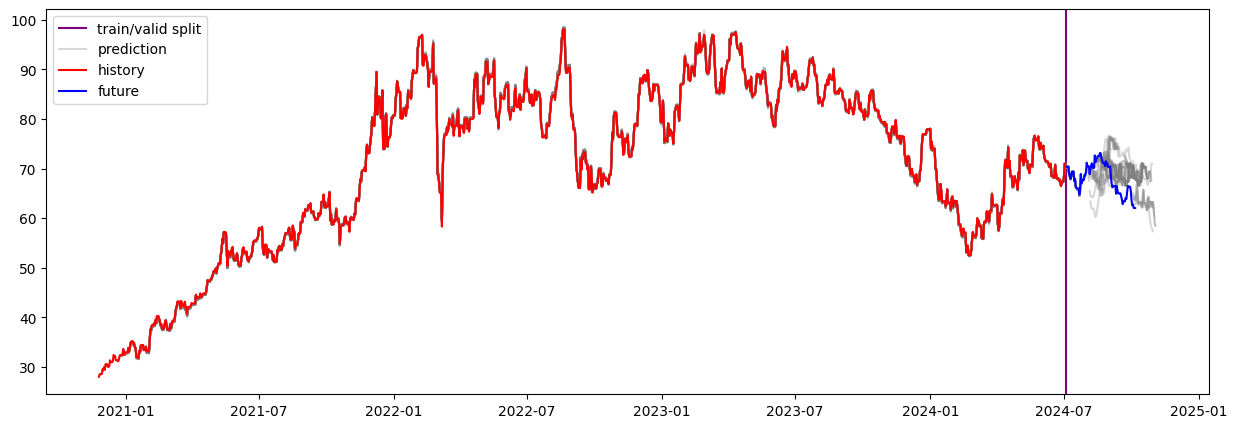

In [288]:
# visuals of train/validation data prediction
train_start_date =  df_all['Date'][0] + pd.to_timedelta(28, unit = 'day')
train_test_split_date = df_all['Date'][0] + pd.to_timedelta(train_size+28, unit = 'day')
from script.post_processing import visual_train_n_valid_data_performance
visual_train_n_valid_data_performance(y_train_pred,y_test_pred, train_start_date, train_test_split_date, df_all)

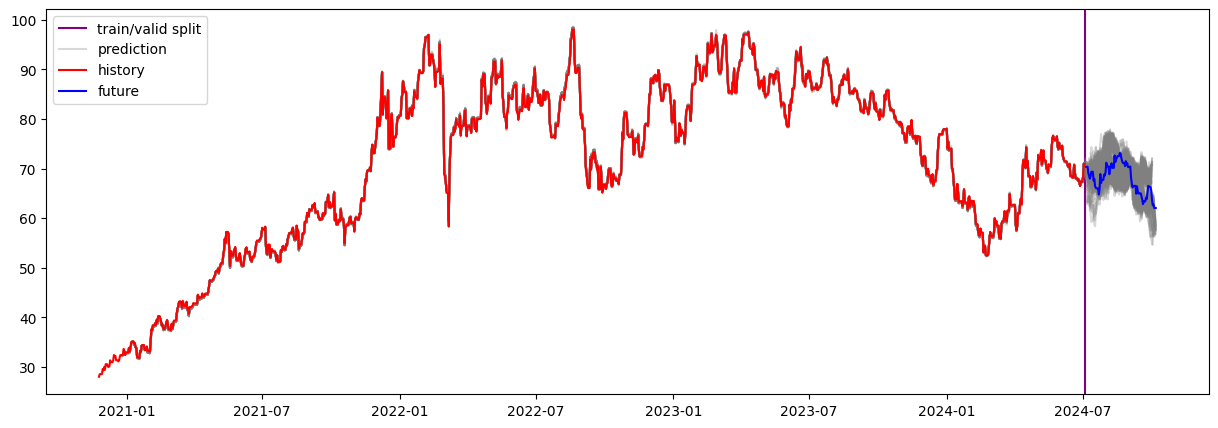

In [310]:
from script.post_processing import visual_train_n_valid_data_performance
visual_train_n_valid_data_performance(y_train_pred,y_test_preds, train_start_date, train_test_split_date, df_all)

In [ ]:
## TODO:
# 1. inverse_transform of variables
# 2. add recursive scheme
# 3. access uncertainty
# 4. check other variables too

In [275]:
from script.post_processing import resursive_furture_prediction, resursive_furture_prediction_with_dropout

In [251]:
future_price, future_time = resursive_furture_prediction(model, X_train_tensor[train_size],
                                                         train_test_split_date = train_test_split_date,
                                                         df_all = df_all)

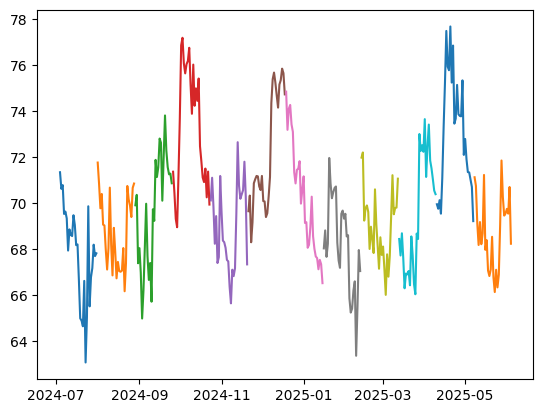

In [253]:
for iter in range(12):
    plt.plot(future_time[iter], future_price[iter][:,0])

In [273]:
future_price_ensemble, future_time = resursive_furture_prediction_with_dropout(model, X_train_tensor[train_size],
                                                         train_test_split_date = train_test_split_date,
                                                         df_all = df_all)

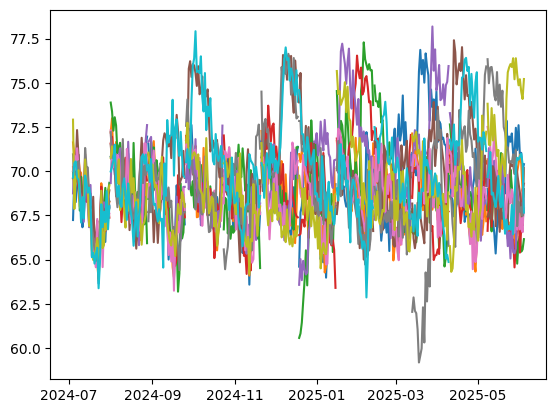

In [274]:
for iter in range(12):
    for real in range(10):
        plt.plot(future_time[iter], future_price_ensemble[real][iter][:,0])

In [ ]:

# 예측된 60일치의 EUA 값만 추출
predicted_eua = test_predictions_rescaled[:30, 0]  # 첫 번째 변수(EUA)만 추출
actual_eua = df_all[df_all['Date'] >= test_date]['EUA'].values[:30]  # 실제 EUA 값

# 60일 동안의 날짜 생성
future_dates = [last_train_date + pd.DateOffset(days=i + 1) for i in range(30)]

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 예측된 EUA 가격 그래프
plt.plot(future_dates, predicted_eua, label='Predicted EUA', color='red', marker='o')

# 실제 EUA 가격 그래프
plt.plot(future_dates, actual_eua, label='Actual EUA', color='blue', linestyle='--')

# 그래프 설정
plt.xlabel('Date')
plt.ylabel('EUA Price')
plt.title('EUA Price Prediction for the Next 60 Days')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()